# Analyzing CIA Factbook Data Using SQLite and Python

In this project, we'll work with data from the [CIA World Factbook](https://www.cia.gov/library/publications/the-world-factbook/), a compendium of statistics about all of the countries on Earth. The Factbook contains demographic information like:

* `population` - The population as of 2015.
* `population_growth` - The annual population growth rate, as a percentage.
* `area` - The total land and water area.

In [1]:
import sqlite3
import pandas as pd
conn = sqlite3.connect("factbook.db")

q = "SELECT * FROM sqlite_master WHERE type='table';"
pd.read_sql_query(q, conn)

,type,name,tbl_name,rootpage,sql
0,table,sqlite_sequence,sqlite_sequence,3,"CREATE TABLE sqlite_sequence(name,seq)"
1,table,facts,facts,47,"CREATE TABLE ""facts"" (""id"" INTEGER PRIMARY KEY..."


In [2]:
q = "SELECT * FROM facts limit 5"
pd.read_sql_query(q, conn)

,id,code,name,area,area_land,area_water,population,population_growth,birth_rate,death_rate,migration_rate
0,1,af,Afghanistan,652230,652230,0,32564342,2.32,38.57,13.89,1.51
1,2,al,Albania,28748,27398,1350,3029278,0.30,12.92,6.58,3.30
2,3,ag,Algeria,2381741,2381741,0,39542166,1.84,23.67,4.31,0.92
3,4,an,Andorra,468,468,0,85580,0.12,8.13,6.96,0.00
4,5,ao,Angola,1246700,1246700,0,19625353,2.78,38.78,11.49,0.46


Here are the descriptions for some of the columns:

* `name` - The name of the country.
* `area` - The total land and sea area of the country.
* `population` - The country's population.
* `population_growth` - The country's population growth as a percentage.
* `birth_rate` - The country's birth rate, or the number of births a year per 1,000 people.
* `death_rate` - The country's death rate, or the number of death a year per 1,000 people.
* `area` - The country's total area (both land and water).
* `area_water` - The country's waterarea in square kilometers.


Let's start by calculating some summary statistics and look for any outlier countries.

In [3]:
q = "SELECT min(population), max(population), min(population_growth), max(population_growth) FROM facts"
pd.read_sql_query(q, conn)

,min(population),max(population),min(population_growth),max(population_growth)
0,0,7256490011,0.0,4.02


A few things stick out from the summary statistics in the last query:

* there's a country with a population of 0
* there's a country with a population of 7256490011 (or more than 7.2 billion people)

Let's zoom in on just these countries.

In [4]:
q = "SELECT * FROM facts where population = 0 or population = 7256490011"
pd.read_sql_query(q, conn)

,id,code,name,area,area_land,area_water,population,population_growth,birth_rate,death_rate,migration_rate
0,250,ay,Antarctica,None,280000.0,None,0,NaN,NaN,NaN,None
1,261,xx,World,None,NaN,None,7256490011,1.08,18.6,7.8,None


It seems like the table contains a row for the whole world, which explains the population of over 7.2 billion. It also seems like the table contains a row for Antarctica, which explains the population of 0. This seems to match the CIA Factbook [page for Antarctica](https://www.cia.gov/library/publications/the-world-factbook/geos/ay.html)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002C704888508>,
      dtype=object)

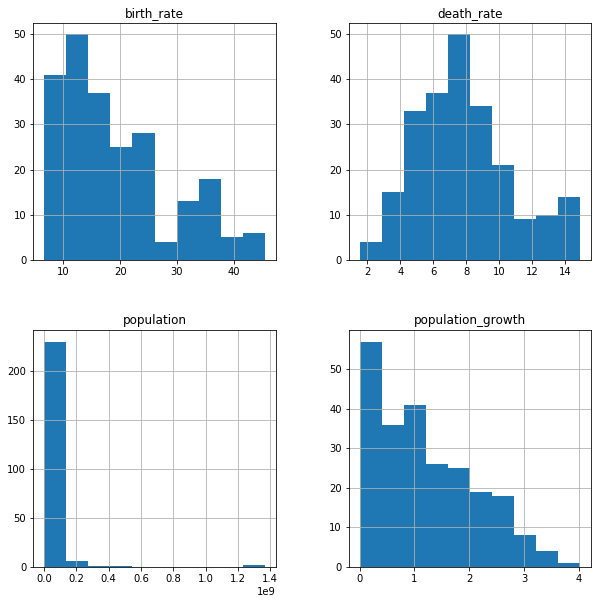

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)

q6 = '''
select population, population_growth, birth_rate, death_rate
from facts
where population != (select max(population) from facts)
and population != (select min(population) from facts);
'''
pd.read_sql_query(q6, conn).hist(ax=ax)

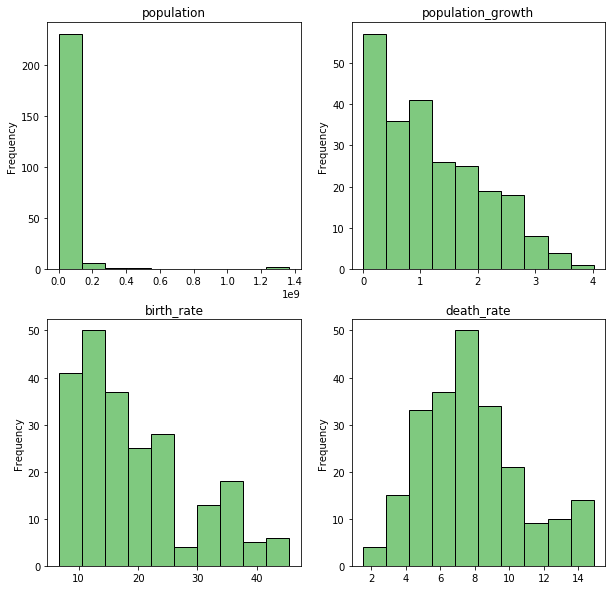

In [6]:
from matplotlib import cm
import numpy as np
country_metrics = pd.read_sql_query(q6, conn)
colors = [plt.cm.Accent(i) for i in np.linspace(0, 1, country_metrics.shape[0])]

fig = plt.figure(figsize=(10,10))

for i, col in enumerate(list(country_metrics.columns)):
    ax = fig.add_subplot(2,2,i+1)
    country_metrics[col].plot.hist(
    ax=ax,
    colormap=plt.cm.Accent,
    edgecolor='black',
    title = col
    )

In [7]:
import matplotlib
matplotlib.__version__

'3.1.1'

In [8]:
pd.read_sql_query(q6, conn)

,population,population_growth,birth_rate,death_rate
0,32564342,2.32,38.57,13.89
1,3029278,0.30,12.92,6.58
2,39542166,1.84,23.67,4.31
3,85580,0.12,8.13,6.96
4,19625353,2.78,38.78,11.49
...,...,...,...,...
235,3598357,0.60,10.86,8.67
236,103574,0.59,10.31,8.54
237,1869055,2.81,31.11,3.04
238,2785366,1.95,22.99,3.50


## Which countries have the highest population density?

In [9]:
q7 = "select name, cast(population as float)/cast(area as float) density from facts order by density desc limit 20"
pd.read_sql_query(q7, conn)

,name,density
0,Macau,21168.964286
1,Monaco,15267.500000
2,Singapore,8141.279770
3,Hong Kong,6445.041516
4,Gaza Strip,5191.819444
5,Gibraltar,4876.333333
6,Bahrain,1771.859211
7,Maldives,1319.640940
8,Malta,1310.015823
9,Bermuda,1299.925926
